In [ ]:
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [ ]:
import tensorflow as tf
import json
from eoflow.models import TransformerEncoder, TempCNNModel, PseTae
from utils.tf_data_utils import *
from utils.globals import *

In [12]:
with open('data/max.json') as f:
  Max = json.load(f)

with open('data/min.json') as f:
  Min = json.load(f)

In [13]:
trainFilePath = 'data/Training_reno_cnn.tfrecord.gz'
testFilePath = 'data/Testing_reno_cnn.tfrecord.gz'
validFilePath = 'data/Valid_reno_cnn.tfrecord.gz'

In [14]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[tsLength], dtype=tf.float32) 
    for k in featureNames
]
# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

# plot time

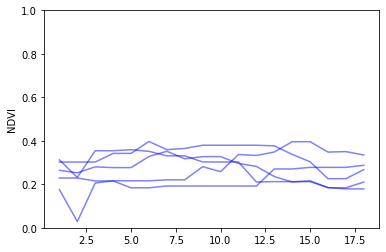

In [7]:
dataset0 = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3,len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn0)

y = iter(dataset0.shuffle(buffer_size=100000, seed=42).batch(5)).next()
y = y['ndvi'].numpy().transpose()
x = np.arange(1, 19, 1)

plt.plot(x, y,color='blue',alpha=0.5)
plt.ylabel('NDVI')
plt.ylim(0,1)
plt.show()

In [ ]:
dataset1 = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3,len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn1)

y = iter(dataset1.shuffle(buffer_size=100000, seed=42).batch(5)).next()
y = y['ndvi'].numpy().transpose()
x = np.arange(1, 19, 1)

plt.plot(x, y,color='blue',alpha=0.5)
plt.ylabel('NDVI')
plt.ylim(0,1)
plt.show()

# data

In [20]:
dataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.shuffle(buffer_size=buff, seed=42)\
.repeat()\
.batch(batch_size)

In [21]:
valDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

In [10]:
# Train model

In [59]:
model_cfg = {
    "learning_rate": lr,
    "n_classes": n_classes,
    "keep_prob": 0.8,
    "metrics": ["accuracy","precision","recall"],
    "loss": "focal_loss",
    "kernel_regularizer": 1e-08,
    "nb_conv_filters": 32,
    "nb_conv_stacks": 3
}
    
# Initialize model with configuration
model = TempCNNModel(model_cfg)

In [60]:
model.build(input_shape)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 18, 18)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 18, 32)            2912      
_________________________________________________________________
activation_12 (Activation)   (None, 18, 32)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 18, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 18, 32)            5152      
_________________________________________________________________
activation_13 (Activation)   (None, 18, 32)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 18, 32)            0   

In [61]:

model.prepare()



In [62]:
model.train_and_evaluate(
    train_dataset=dataset,
    val_dataset=valDataset,
    num_epochs=epochs,
    iterations_per_epoch=steps,
    model_directory=model_directory,
    save_steps='epoch',
    summary_steps='epoch'
)

Epoch 1/3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 18, 18)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 32)            2912      
_________________________________________________________________
activation (Activation)      (None, 18, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 32)            5152      
_________________________________________________________________
activation_1 (Activation)    (None, 18, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 32)        

In [63]:
model.evaluate(valDataset,verbose=0,return_dict=True)

In [ ]:
model.save('save_test')

In [65]:
#new_model = tf.keras.models.load_model('save_test', compile=False)
#new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=CategoricalFocalLoss(from_logits=False, class_weights=None), metrics= [tf.keras.metrics.Precision(class_id=0, name='p_0'),tf.keras.metrics.Precision(class_id=1, name='p_1'),
#      tf.keras.metrics.Recall(class_id=0, name='recall_0'),tf.keras.metrics.Recall(class_id=1, name='recall_1')])
#new_model.evaluate(valDataset,verbose=0,return_dict=True)

INFO:tensorflow:Assets written to: save_test/assets


2021-04-07 09:54:51,778 INFO Assets written to: save_test/assets


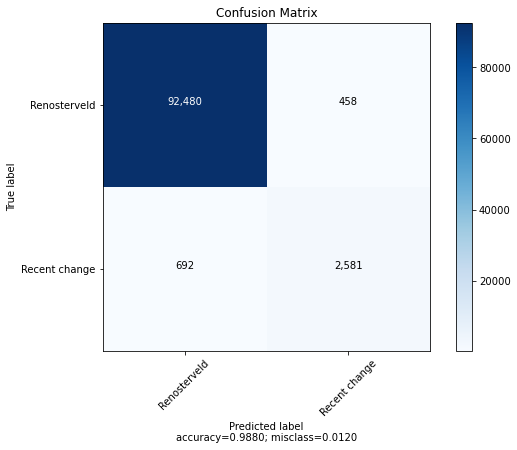

In [25]:
predictions = model.predict(valDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = valDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

# test data

In [26]:
# List of fixed-length features, all of which are float32.
testcolumns = [
  tf.io.FixedLenFeature(shape=[testLength], dtype=tf.float32) 
    for k in testNames
]
# Dictionary with names as keys, features as values.
testfeaturesDict = dict(zip(testNames, testcolumns))

In [27]:
testDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: popkey(x,['ndvi_diff','roll','count']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

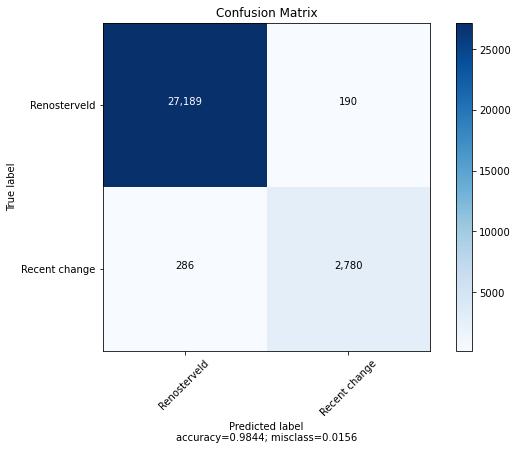

In [28]:
predictions = model.predict(testDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [32]:
pred_y =  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.map(lambda x: labeller(x, 'roll'))\
.filter(filter_fn)\
.map(lambda x: poplabint(x, 'roll'))\
.batch(batch_size)\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

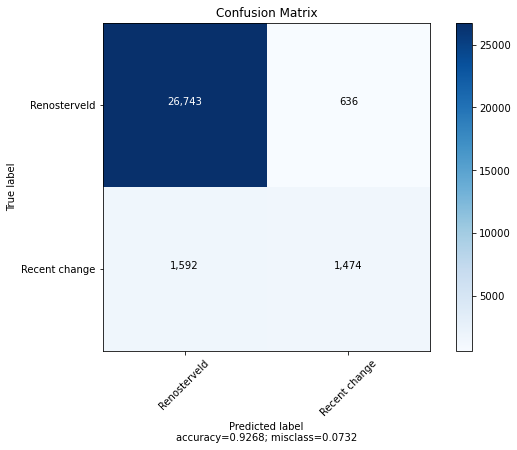

In [33]:
pred_y = list(pred_y)
pred_y = np.vstack(pred_y)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")